This skeleton code will get you started with the assignment.

For this assignment you will need at least:

- Pytorch 1.13+
- Sklearn
- Matplotlib

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from IPython.display import Audio
from torchsummary import summary

#possibly unnecessary:
import torch.nn as nn
import torch.utils.data as data_utils
import logging
from torch import optim
from torchaudio import transforms

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cpu


### Data Loading
The data consists of waveforms of audioclips sampled 8000 times per second (8 khz).
The data is stored in 16 bit precision to reduce storage size. We first need to
convert the waveforms to 32 bit precision.

In [3]:
sampling_rate = 8_000
languages = ["de", "en", "es", "fr", "nl", "pt"]
language_dict = {languages[i]: i for i in range(len(languages))}

X_train, y_train = np.load("dataset/inputs_train_fp16.npy"), np.load(
    "dataset/targets_train_int8.npy"
)
X_test, y_test = np.load("dataset/inputs_test_fp16.npy"), np.load(
    "dataset/targets_test_int8.npy"
)

X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

#X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Change the `selected_language` to any of the 6 language codes, and re-run the cell below to hear some random clips from the training data.

In [4]:
selected_language = "nl"
idxs = np.where(y_train == language_dict[selected_language])[0]
idx = np.random.choice(idxs)

Audio(X_train[idx], rate=sampling_rate)


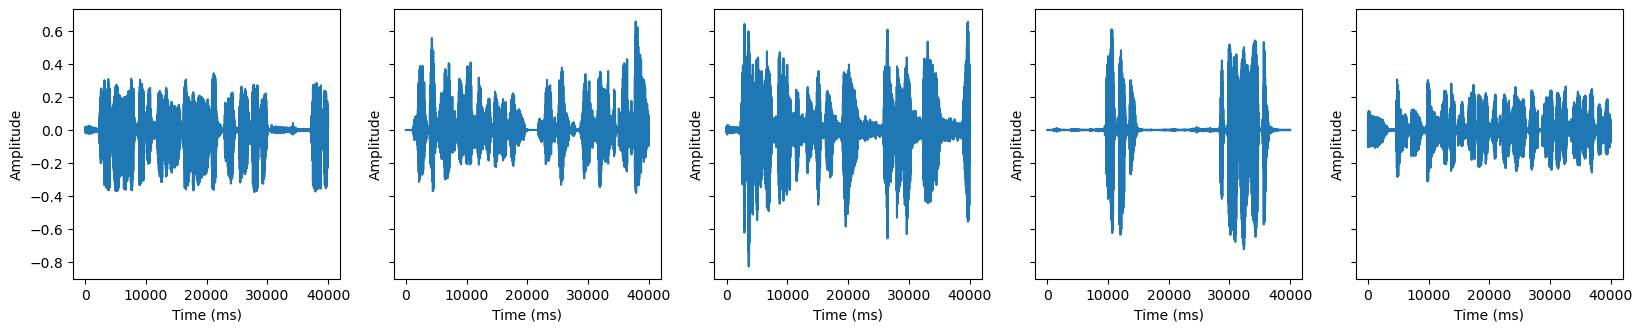

In [5]:
indexes_random = np.random.choice(6000, 5)

time = np.linspace(0, 39999, 40000)

fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey = True)
for ax, audio_index in zip(axes,indexes_random):
    ax.plot(time, X_train[audio_index])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')


### Data pre-processing

It is important that data preprocessing takes place in the model itself,
as only the model will be uploaded to the competition server.

So, rather than the usual, we will perform normalization and other preprocessing
steps as layers of the network. To help you with this, we provide an example of
a bogus normalization below.


Here, we multiply the input by a constant and subtract the max of each sample.
Follow this format to create your own normalization layer(s).

In [6]:
# normalization with MFCC

class MFCC_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.sample_rate = 40000/5
        self.transform_MFCC = transforms.MFCC(sample_rate = self.sample_rate)

    def forward(self, x):
        with torch.no_grad():
            x = self.transform_MFCC(x)
        return x
    
MFCC_transformation = MFCC_layer()

In [7]:
# testing different mfcc methods
'''
tensor_X_train = torch.tensor(X_train_sub)

transformed_tensor = MFCC_transformation(tensor_X_train)

import librosa
from matplotlib import cm

img = tensor_X_train[0]
print(img)
print(img.shape)

y = np.array(img)
sr = 40000/5

new = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
print(mfcc.shape)

plt.figure(figsize=(6, 4))
librosa.display.specshow(new, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,3.5))
plt.imshow(old, cmap=cm.magma, origin = 'lower')
plt.xlabel('Freq_bins')
plt.ylabel('Coefficients')
plt.title("MFCC")
plt.show()
'''

'\ntensor_X_train = torch.tensor(X_train_sub)\n\ntransformed_tensor = MFCC_transformation(tensor_X_train)\n\nimport librosa\nfrom matplotlib import cm\n\nimg = tensor_X_train[0]\nprint(img)\nprint(img.shape)\n\ny = np.array(img)\nsr = 40000/5\n\nnew = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)\nprint(mfcc.shape)\n\nplt.figure(figsize=(6, 4))\nlibrosa.display.specshow(new, x_axis=\'time\')\nplt.colorbar()\nplt.title(\'MFCC\')\nplt.tight_layout()\nplt.show()\n\nplt.figure(figsize=(20,3.5))\nplt.imshow(old, cmap=cm.magma, origin = \'lower\')\nplt.xlabel(\'Freq_bins\')\nplt.ylabel(\'Coefficients\')\nplt.title("MFCC")\nplt.show()\n'

In [7]:
# isolating english and spanish for the initial model creation

idxs = np.where((y_train == language_dict['en'])|(y_train == language_dict['es'])) 
#idxs_valid = np.where((y_valid == language_dict['en'])|(y_valid == language_dict['es'])) 
idxs_test = np.where((y_test == language_dict['en'])|(y_test == language_dict['es'])) 

y_train_sub = y_train[idxs]-1
X_train_sub = X_train[idxs]

#y_valid_sub = y_valid[idxs_valid]-1
#X_valid_sub = X_valid[idxs_valid]

y_test_sub = y_test[idxs_test]-1
X_test_sub = X_test[idxs_test]

print(np.shape(X_train_sub)) #samples, timesteps
#print(np.shape(X_valid_sub))
print(np.shape(X_test_sub))


(2000, 40000)
(400, 40000)


### One-Hot Encoder

In [9]:
"""""
# makeshift one hot encoder
y_train_sub_ohe = y_train_sub - 1
y_test_sub_ohe = y_test_sub - 1

y_train_spain_ohe = np.array([1 if x == 0 else 0 for x in y_train_sub_ohe])
y_train_english_ohe = y_train_sub_ohe

y_test_spain_ohe = np.array([1 if x == 0 else 0 for x in y_test_sub_ohe])
y_test_english_ohe = y_test_sub_ohe

#print(y_train_spain_ohe[:5])
#print(y_train_english_ohe[:5])

y_train_sub = np.array([y_train_spain_ohe, y_train_english_ohe])
y_test_sub = np.array([y_test_spain_ohe, y_test_english_ohe])

print(y_train_sub)
#print(y_test_sub)

print(y_train_sub.shape)
print(y_test_sub.shape)

y_train_sub = np.swapaxes(y_train_sub, 0, 1)
y_test_sub = np.swapaxes(y_test_sub, 0, 1)

print(y_train_sub.shape)
print(y_test_sub.shape)
"""""

'""\n# makeshift one hot encoder\ny_train_sub_ohe = y_train_sub - 1\ny_test_sub_ohe = y_test_sub - 1\n\ny_train_spain_ohe = np.array([1 if x == 0 else 0 for x in y_train_sub_ohe])\ny_train_english_ohe = y_train_sub_ohe\n\ny_test_spain_ohe = np.array([1 if x == 0 else 0 for x in y_test_sub_ohe])\ny_test_english_ohe = y_test_sub_ohe\n\n#print(y_train_spain_ohe[:5])\n#print(y_train_english_ohe[:5])\n\ny_train_sub = np.array([y_train_spain_ohe, y_train_english_ohe])\ny_test_sub = np.array([y_test_spain_ohe, y_test_english_ohe])\n\nprint(y_train_sub)\n#print(y_test_sub)\n\nprint(y_train_sub.shape)\nprint(y_test_sub.shape)\n\ny_train_sub = np.swapaxes(y_train_sub, 0, 1)\ny_test_sub = np.swapaxes(y_test_sub, 0, 1)\n\nprint(y_train_sub.shape)\nprint(y_test_sub.shape)\n'

### MFCC transformation on X_train and X_test
+turning it into tensors

In [8]:
# input
tensor_X_train = torch.tensor(X_train_sub)
tensor_X_test = torch.tensor(X_test_sub)

# target
tensor_y_train = torch.tensor(y_train_sub)
tensor_y_test = torch.tensor(y_test_sub)

### Plot of non-normalized vs normalized data

In [11]:
"""
# transforming the dataset to MFCC

from matplotlib import cm

transformed_array = np.array(tensor_X_train)

indexes = [100, 200, 300, 400, 500]

fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True, dpi=80)
time = np.linspace(0, 39999, 40000)

for ax, audio_index in zip(axes,indexes):
    ax.plot(time, X_train_sub[audio_index])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')

plt.savefig('waveform graphs.png')


fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True, dpi=80)
for ax, audio_index in zip(axes,indexes):
    ax.imshow(transformed_array[audio_index], cmap=cm.magma, origin = 'lower')
    ax.set_xlabel('Freq_bins')
    ax.set_ylabel('Coefficients')
    ax.set_title("MFCC")
    
#plt.savefig('spectrograms.png')
"""

'\n# transforming the dataset to MFCC\n\nfrom matplotlib import cm\n\ntransformed_array = np.array(tensor_X_train)\n\nindexes = [100, 200, 300, 400, 500]\n\nfig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True, dpi=80)\ntime = np.linspace(0, 39999, 40000)\n\nfor ax, audio_index in zip(axes,indexes):\n    ax.plot(time, X_train_sub[audio_index])\n    ax.set_xlabel(\'Time (ms)\')\n    ax.set_ylabel(\'Amplitude\')\n\nplt.savefig(\'waveform graphs.png\')\n\n\nfig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True, dpi=80)\nfor ax, audio_index in zip(axes,indexes):\n    ax.imshow(transformed_array[audio_index], cmap=cm.magma, origin = \'lower\')\n    ax.set_xlabel(\'Freq_bins\')\n    ax.set_ylabel(\'Coefficients\')\n    ax.set_title("MFCC")\n    \n#plt.savefig(\'spectrograms.png\')\n'

### CNN model

In [9]:
# Create a sequential model - CNN
# (batch, channel, image height, image width)

model = nn.Sequential(MFCC_transformation)

# Add convolutional and pooling layers
model.add_module('Conv_1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1))
model.add_module('BatchNorm_1', nn.BatchNorm2d(num_features=32))
model.add_module('Relu_1', nn.ReLU())
model.add_module('MaxPool_1', nn.MaxPool2d(kernel_size=2, padding=1))

model.add_module('Conv_2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1))
model.add_module('BatchNorm_2', nn.BatchNorm2d(num_features=64))
model.add_module('Relu_2', nn.ReLU())
model.add_module('MaxPool_2', nn.MaxPool2d(kernel_size=2, padding=1))

model.add_module('Conv_3', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1))
model.add_module('BatchNorm_3', nn.BatchNorm2d(num_features=64))
model.add_module('Relu_3', nn.ReLU())

#"""""
model.add_module('Flatten', nn.Flatten())
# in_features for linear layer should be the multiplication of the last 3 digits of the ReLU-8 output shape (64*11*51)
# which is equal to the last number in the Flatten output shape (35904)
model.add_module('Linear_1', nn.Linear(in_features=64*11*51, out_features=64, bias=True))
model.add_module('BatchNorm_4', nn.BatchNorm1d(num_features=64)) 
model.add_module('Relu_L_1', nn.ReLU())
model.add_module('Linear_2', nn.Linear(in_features=64, out_features=1, bias=True))
model.add_module('BatchNorm_5', nn.BatchNorm1d(num_features=1)) 
model.add_module('Out_activation', nn.Sigmoid())
#"""""

model = model.to(device)

summary(model, input_size = (1, 40000)) # testing input size without defined batch_size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       Spectrogram-1          [-1, 1, 201, 201]               0
          MelScale-2          [-1, 1, 128, 201]               0
    MelSpectrogram-3          [-1, 1, 128, 201]               0
     AmplitudeToDB-4          [-1, 1, 128, 201]               0
              MFCC-5           [-1, 1, 40, 201]               0
        MFCC_layer-6           [-1, 1, 40, 201]               0
            Conv2d-7          [-1, 32, 40, 201]             320
       BatchNorm2d-8          [-1, 32, 40, 201]              64
              ReLU-9          [-1, 32, 40, 201]               0
        MaxPool2d-10          [-1, 32, 21, 101]               0
           Conv2d-11          [-1, 64, 21, 101]          18,496
      BatchNorm2d-12          [-1, 64, 21, 101]             128
             ReLU-13          [-1, 64, 21, 101]               0
        MaxPool2d-14           [-1, 64,

In [10]:
BATCH_SIZE = 64 #aka channels 
training = tensor_X_train
target_train = tensor_y_train.float().unsqueeze(1)

test = tensor_X_test
target_test = tensor_y_test.float().unsqueeze(1)

train_dataset = data_utils.TensorDataset(training.unsqueeze(1), target_train) # unsqueeze so it gets shape (64, 1, 40, 201)
train_loader = data_utils.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE) 

test_dataset = data_utils.TensorDataset(test.unsqueeze(1), target_test)
test_loader = data_utils.DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [14]:
print(training.shape, target_train.shape)
print(training.shape)
print(test.shape)
print(target_train.shape)
print(len(train_loader))
print(len(test_loader))

torch.Size([2000, 40000]) torch.Size([2000, 1])
torch.Size([2000, 40000])
torch.Size([400, 40000])
torch.Size([2000, 1])
200
40


In [15]:
#training model and obtaining test score
#iterations = number of batches needed to complete one epoch, which is BATCH_SIZE 

optimizer = optim.Adam(model.parameters(), lr=0.001) #lr=0.0001 is worth a try but takes a long time. Try 0.0005 next
crossentropy_loss = nn.BCELoss(reduction='mean')

num_epochs = 5
iterations = 0

train_loss = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    model.train() 
    
    for images, labels in train_loader: 

        model.train()

        images = images.to(device)
        labels = labels.to(device)
        
        #forward pass
        predictions = model(images)  
        loss = crossentropy_loss(predictions, labels) 
        
        #backwards pass
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()
        
        #save the training and testing loss for every 10 iterations, since batch_size is set to 10 and every epoch goes over a batch
        iterations += 1
        if iterations % 10 == 0: 
            train_loss.append(loss.detach().numpy())

            current_test_loss = []
            current_test_acc = []
            with torch.no_grad(): #clears memory
                for images, labels in test_loader: 
                    model.eval()
                    
                    images, labels = images.to(device), labels.to(device)
                    predictions = model(images)

                    loss = crossentropy_loss(predictions, labels)
                    current_test_loss.append(loss.detach().numpy())

                    accuracy = (predictions.round() == labels).float().mean()
                    current_test_acc.append(accuracy.item())

            loss = sum(current_test_loss)/len(current_test_loss)
            accuracy = sum(current_test_acc)/len(current_test_acc)

            test_loss.append(loss)
            test_accuracy.append(accuracy)

        model.train()
            
print(accuracy)

0.8214285714285714


32
7
16
16


<function matplotlib.pyplot.show(close=None, block=None)>

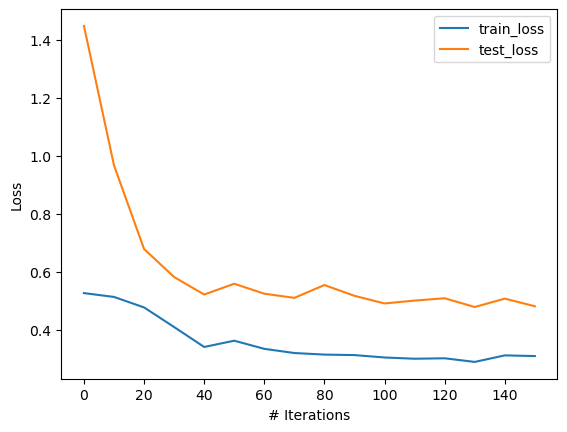

In [35]:
print(len(train_loader))
print(len(test_loader))

print(len(train_loss))
print(len(test_loss))
plt.plot(10*np.arange(0, len(train_loss)), train_loss, label='train_loss')
plt.plot(10*np.arange(0, len(test_loss)), test_loss, label='test_loss')
plt.xlabel("# Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show

### Full Data Model

In [ ]:

#model = nn.Sequential(MFCC_transformation)

class Model(nn.Sequential):
    def __init__(self):
        super(Model, self).__init__()

        self.Mfcc = MFCC_transformation
        self.Conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1)
        self.Relu_1 = nn.ReLU()
        self.BatchNorm_1 = nn.BatchNorm2d(num_features=32)
        self. MaxPool_1 = nn.MaxPool2d(kernel_size=2, padding=1)

        self.Conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.Relu_2 = nn.ReLU()
        self.BatchNorm_2 = nn.BatchNorm2d(num_features=64)
        self.MaxPool_2 = nn.MaxPool2d(kernel_size=2, padding=1)

        self.Conv_3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1)
        self.Relu_3 = nn.ReLU()
        self.BatchNorm_3 = nn.BatchNorm2d(num_features=64)

        self.Flatten = nn.Flatten()
        # in_features for linear layer should be the multiplication of the last 3 digits of the ReLU-8 output shape (64*11*51)
        # which is equal to the last number in the Flatten output shape (35904)
        self.Linear_1 = nn.Linear(in_features=64*11*51, out_features=64, bias=True)
        self.Relu_L_1 = nn.ReLU()
        self.BatchNorm_4 = nn.BatchNorm1d(num_features=64)
        self.Linear_2 = nn.Linear(in_features=64, out_features=1, bias=True)
        self.BatchNorm_5 = nn.BatchNorm1d(num_features=1)
        self.Out_activation = nn.Sigmoid()
    
    def normalize(self, inputs):
        mf = self.Mfcc

    def forward(self, mf):
        c1 = self.Conv_1(inputs)
        b1 = self.BatchNorm_1(c1)
        r1 = self.Relu_1(b1)
        m1 = self.MaxPool_1(r1)

        c2 = self.Conv_2(m1)
        b2 = self.BatchNorm_1(c2)
        r2 = self.Relu_1(b2)
        m2 = self.MaxPool_2(r2)

        c3 = self.Conv_3(m2)
        b3 = self.BatchNorm_1(c3)
        r3 = self.Relu_1(b3)
        x = self.Flatten(r3)

        x = self.Linear_1(x)
        x = self.BatchNorm_1(x)
        x = self.Relu_1(x)
        x = self.Linear_2(x)
        x = self.BatchNorm_5(x)
        x = self.Out_activation(x)

        return x


In [ ]:
# input
tensor_X_train_ = torch.tensor(X_train)
tensor_X_test_ = torch.tensor(X_test)

# target
tensor_y_train_ = torch.tensor(y_train)
tensor_y_test_ = torch.tensor(y_test)

tensor_X_train_.shape
tensor_X_test_.shape
model_ = Model().to(device)
summary(model_, input_size = (1, 40000))

In [ ]:
BATCH_SIZE = 64 #aka channels
training = tensor_X_train_
target_train = tensor_y_train_.float().unsqueeze(1)

test = tensor_X_test_
target_test = tensor_y_test_.float().unsqueeze(1)

train_dataset = data_utils.TensorDataset(training.unsqueeze(1), target_train) # unsqueeze so it gets shape (64, 1, 40, 201)
train_loader = data_utils.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE) 

test_dataset = data_utils.TensorDataset(test.unsqueeze(1), target_test)
test_loader = data_utils.DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
# training model and obtaining test score

optimizer = optim.Adam(model.parameters(), lr=0.001) 
crossentropy_loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 5

training_loss = []
test_loss = []

model.train() 

for epoch in range(num_epochs):
    for images, labels in train_loader: 
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()   
        predictions = model(images)     
        loss = crossentropy_loss(predictions, labels) 
        training_loss.append(loss.detach().numpy())
        loss.backward() 
        optimizer.step()

model.eval() 

test_acc = 0 
for images, labels in test_loader: 
    images, labels = images.to(device), labels.to(device)
    predictions = model(images)
    loss = crossentropy_loss(predictions, labels)
    test_loss.append(loss.detach().numpy())
    #accuracy = (torch.max(predictions, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
    accuracy=(predictions.round() == labels).float().mean()
    test_acc += accuracy.item()
    
test_acc /= len(test_loader)
plt.plot(training_loss, label='train_loss')
plt.plot(test_loss, label='test_loss') # test loss is empty and I don't know why, how can we fix this?
plt.legend()
plt.show

print(f"test accuracy = {test_acc}")

### Model saving

We need to save the model using torchscript, in order to upload the model file to the competition server.
This may give errors for the following reason:

* In your model class, or layer classes, you use numpy functions or arrays, rather than tensors.

Thus make sure that you use torch tensors and functions inside these classes. Almost any numpy function
can also be performed using torch. Look at the torch documentation for further reference.

Saving the model to torchscript

In [19]:
torch.jit.save(torch.jit.script(model), "b64l0-001.pt")

### Loading the model from torchscript

This is what the competition server will be doing with your uploaded model.

In [ ]:
model = torch.jit.load("model_test.pt")

In [ ]:
model(inputs)

### Making a PCA plot of the output space

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Below we generate some random model outptus and targets, you must replace these with your own model's
output and the corresponding true targets.

In [ ]:
model_outputs = torch.randn(1200, 6)
targets = torch.randint(0, 6, (1200,))

In [ ]:
outputs_PCA = PCA(n_components=2).fit_transform(model_outputs)

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(*outputs_PCA.T, c=targets, cmap="tab10", alpha=0.3)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
# set legend labels as languages
for i, text in enumerate(legend1.get_texts()):
    text.set_text(languages[i]);